## DBSCAN (Core)

Descripción:

En esta actividad, implementarás el algoritmo DBSCAN para detectar patrones de agrupamiento y encontrar clientes atípicos en el dataset «Wholesale Customers Data» disponible en Kaggle. DBSCAN es ideal para detectar clusters de forma arbitraria y encontrar puntos atípicos (outliers), lo que es útil en escenarios donde los datos no forman clusters esféricos como en el caso de K-means.

Enlace al dataset: [Wholesale](https://www.kaggle.com/binovi/wholesale-customers-data)



Objetivo:

El objetivo principal de esta actividad es aplicar el algoritmo DBSCAN para identificar clusters y clientes atípicos en el dataset. El enfoque está en comprender cómo DBSCAN maneja los outliers y su capacidad para detectar agrupamientos densos.





Instrucciones:

1. Carga de datos:
  - Descarga y carga el dataset de Kaggle. Realiza una exploración inicial del dataset, identificando las variables que consideras importantes para el agrupamiento.
  - El dataset contiene información sobre diferentes tipos de clientes y su comportamiento de compra, lo que incluye variables como el gasto anual en distintas categorías de productos.


In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# importar el dataset 
df = pd.read_csv('../data/Wholesale customers data.csv')
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [4]:
#Codigo para detectar outliers usando el IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)

In [5]:
#Verificamos los tipos de variables numéricas
numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [6]:
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = detect_outliers_iqr(df[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': df[column][~outliers].min(),
        'Upper Bound': df[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
Channel,0.0,0.000000,1.0,2.0
Region,0.0,0.000000,1.0,3.0
Fresh,20.0,4.545455,3.0,37036.0
Milk,28.0,6.363636,55.0,15488.0
Grocery,24.0,5.454545,3.0,23127.0
Frozen,43.0,9.772727,25.0,7683.0
Detergents_Paper,30.0,6.818182,3.0,9265.0
Delicassen,27.0,6.136364,3.0,3637.0


No se encontraron datos anomalos con relevancia para ser transformados y para la mejor comprension de DBSCAN del dataset se decide proceder sin cambios para el modelado.


2. Exploración y preprocesamiento de datos:
  - Realiza un análisis exploratorio de los datos, incluyendo un resumen estadístico de las variables. Es importante entender la distribución de los datos antes de aplicar el modelo de DBSCAN.
  - Asegúrate de estandarizar los datos antes de ejecutar DBSCAN, ya que este algoritmo es sensible a la escala de las variables.
  - Considera la posibilidad de eliminar o tratar valores atípicos que puedan afectar el rendimiento del algoritmo.


In [7]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


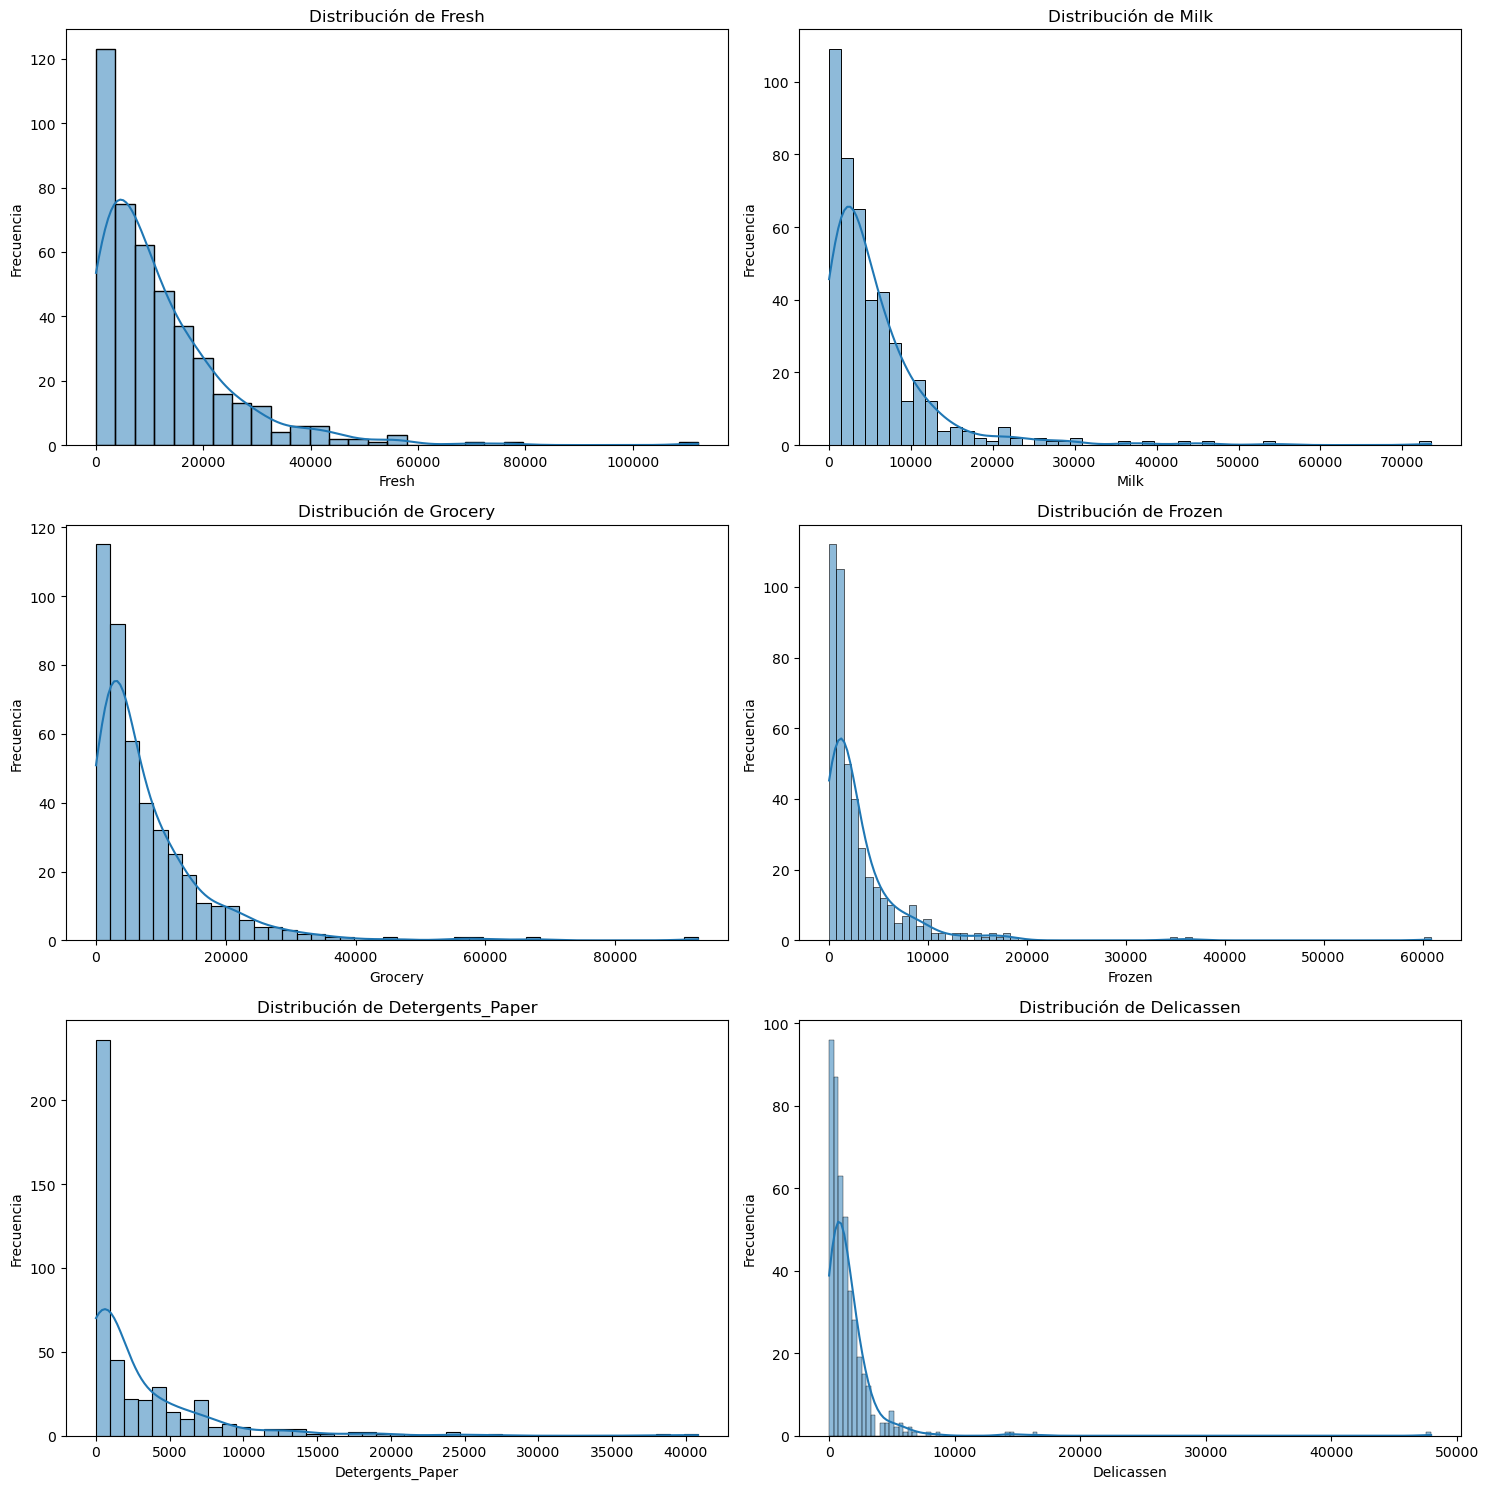

In [8]:
# visualizar en histogramas las variables numericas continuas
# Número de columnas para el grid
num_cols = 2

# Seleccionar las columnas numéricas que no son 'Channel' ni 'Region'
numeric_columns = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Calcular el número de filas necesarias
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols

# Crear subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Crear histogramas para cada columna numérica
for i, column in enumerate(numeric_columns):
    sns.histplot(data=df, x=column, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecuencia')

# Eliminar subplots vacíos si existen
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout
plt.tight_layout()
plt.show()


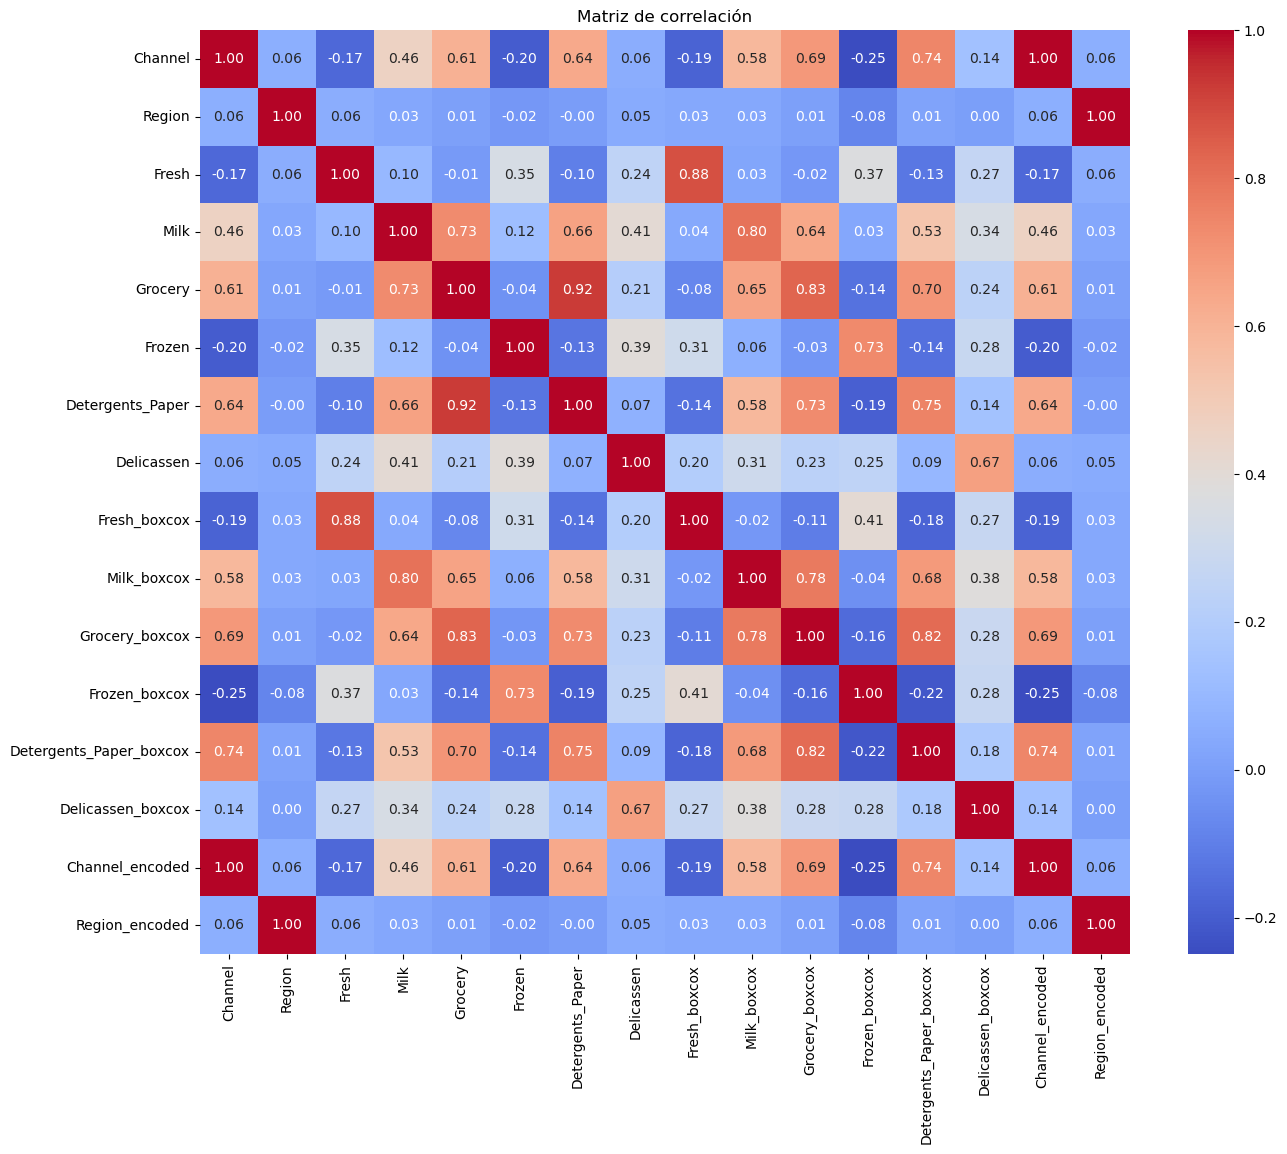

In [18]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()


In [9]:
from scipy.stats import boxcox

# Aplicar transformación Box-Cox a las variables relevantes
df['Fresh_boxcox'], _ = boxcox(df['Fresh'] + 1)
df['Milk_boxcox'], _ = boxcox(df['Milk'] + 1)
df['Grocery_boxcox'], _ = boxcox(df['Grocery'] + 1)
df['Frozen_boxcox'], _ = boxcox(df['Frozen'] + 1)
df['Detergents_Paper_boxcox'], _ = boxcox(df['Detergents_Paper'] + 1)
df['Delicassen_boxcox'], _ = boxcox(df['Delicassen'] + 1)


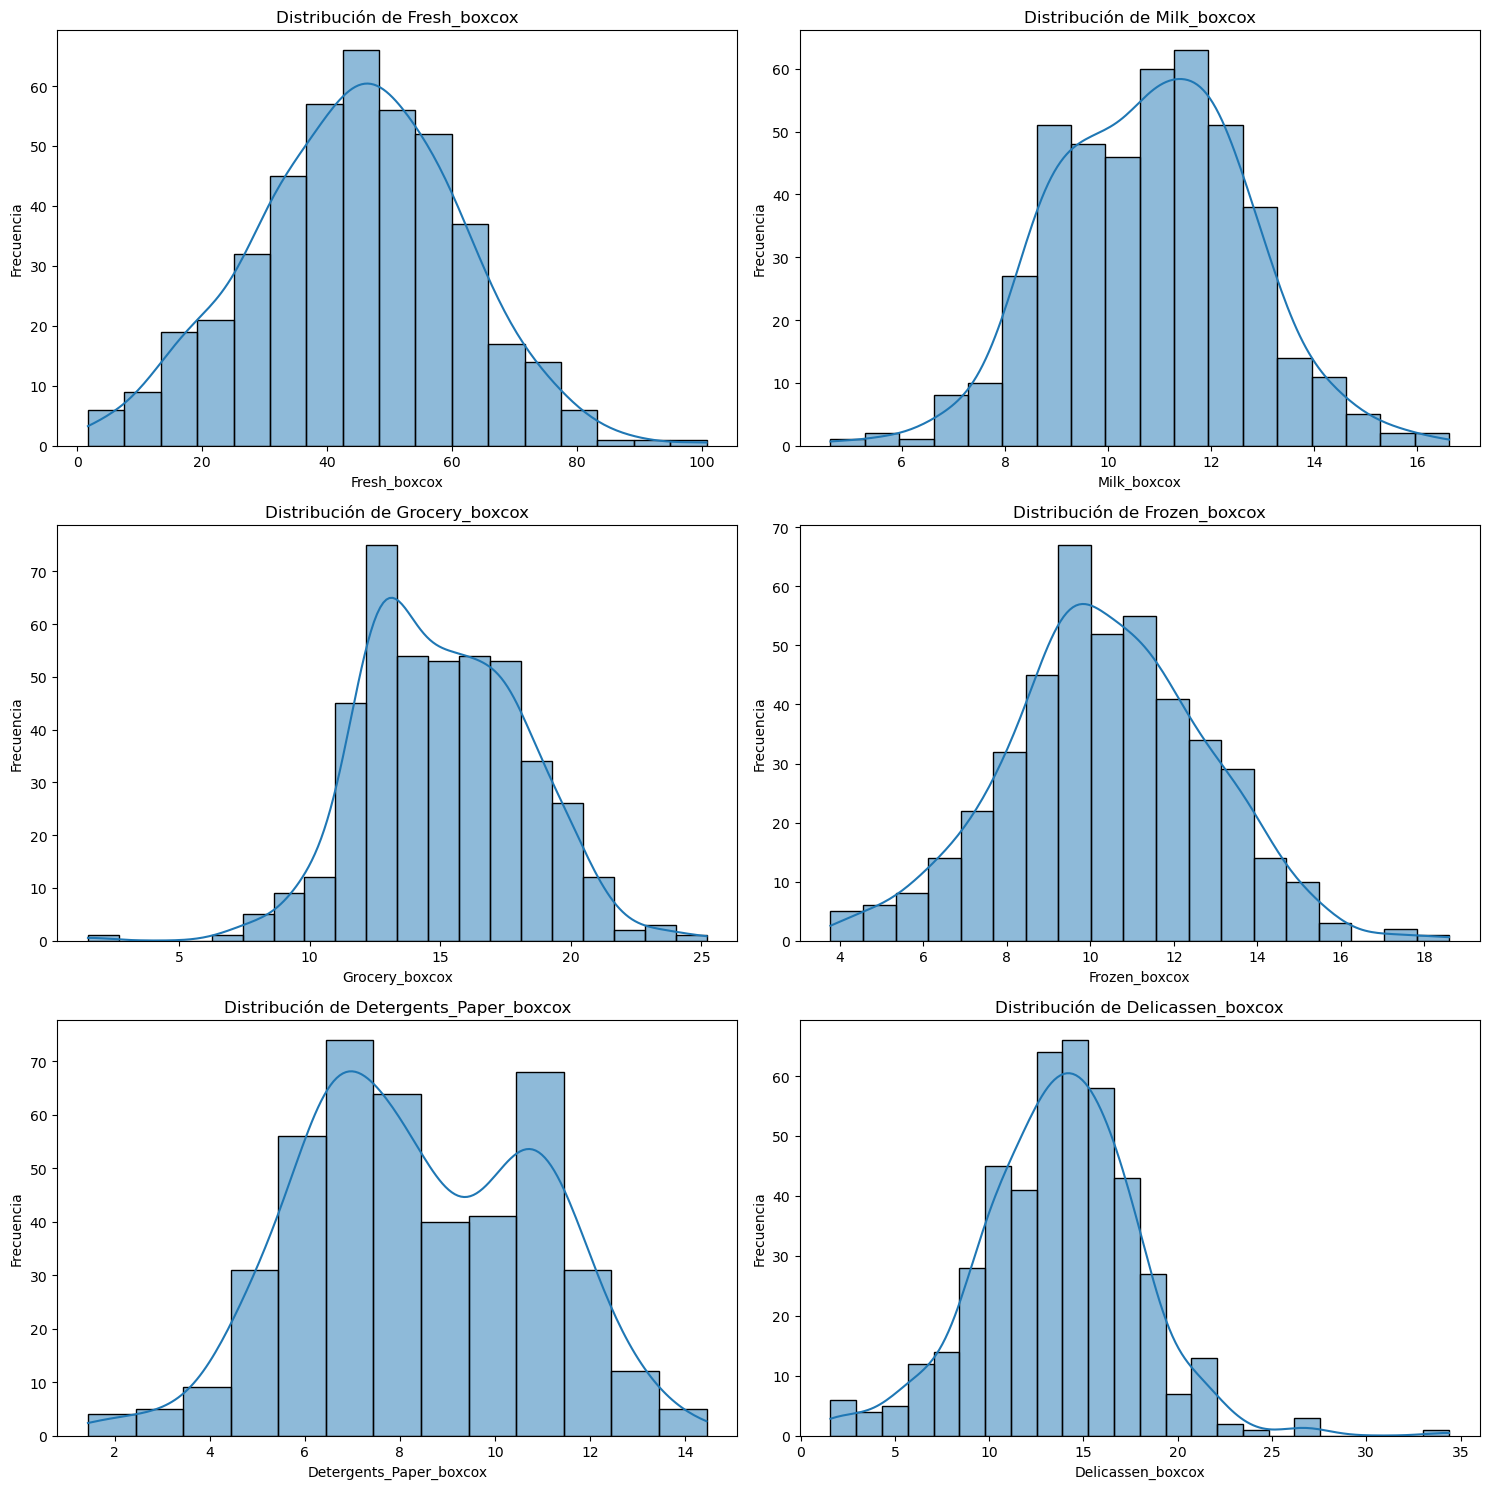

In [10]:
# Visualizar transformaciones logarítmicas
box_columns = ['Fresh_boxcox', 'Milk_boxcox', 'Grocery_boxcox', 'Frozen_boxcox', 'Detergents_Paper_boxcox', 'Delicassen_boxcox']
num_cols = 2
num_rows = (len(box_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(box_columns):
    sns.histplot(data=df, x=column, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecuencia')

# Eliminar subplots vacíos si existen
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [11]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Fresh_boxcox,Milk_boxcox,Grocery_boxcox,Frozen_boxcox,Detergents_Paper_boxcox,Delicassen_boxcox
0,2,3,12669,9656,7561,214,2674,1338,51.417788,12.627966,16.321113,6.865346,9.898261,15.099508
1,2,3,7057,9810,9568,1762,3293,1776,42.744813,12.657043,17.042362,10.573007,10.222421,16.203524
2,2,3,6353,8808,7684,2405,3516,7844,41.339327,12.459656,16.369882,11.181489,10.325210,23.048894
3,1,3,13265,1196,4221,6404,507,1788,52.164602,9.046366,14.623168,13.209915,7.440912,16.230491
4,2,3,22615,5410,7198,3915,1777,5185,61.612660,11.584136,16.173019,12.168787,9.272923,20.947768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,67.045292,13.037918,18.698219,14.813103,6.039063,17.085180
436,1,3,39228,1431,764,4510,93,2346,73.055834,9.334791,10.297295,12.463501,5.166199,17.346803
437,2,3,14531,15488,30243,437,14841,1867,53.675687,13.509508,20.887194,8.043217,12.681387,16.404436
438,1,3,10290,1981,2232,1038,168,2125,48.162499,9.866602,12.902328,9.575766,5.933083,16.933630


In [12]:
X = df[box_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a DataFrame para mantener los nombres de las columnas
X_scaled_df = pd.DataFrame(X_scaled, columns=box_columns)

# Aplicar LabelEncoder a 'Channel' y 'Region'
le = LabelEncoder()
df['Channel_encoded'] = le.fit_transform(df['Channel']) 
df['Region_encoded'] = le.fit_transform(df['Region']) 
# Combinar las columnas codificadas y escaladas 
final_df = pd.concat([df[['Channel_encoded', 'Region_encoded']], X_scaled_df], axis=1)

# Mostrar las primeras filas del DataFrame combinado
print(final_df.head())


   Channel_encoded  Region_encoded  Fresh_boxcox  Milk_boxcox  Grocery_boxcox  \
0                1               2      0.413012     0.979454        0.394901   
1                1               2     -0.110911     0.995243        0.628376   
2                1               2     -0.195814     0.888063        0.410688   
3                0               2      0.458126    -0.965336       -0.154740   
4                1               2      1.028870     0.412660        0.346961   

   Frozen_boxcox  Detergents_Paper_boxcox  Delicassen_boxcox  
0      -1.457973                 0.620530           0.338074  
1       0.080081                 0.751556           0.602222  
2       0.332499                 0.793104           2.240051  
3       1.173953                -0.372736           0.608674  
4       0.742061                 0.367767           1.737333  



3. Aplicación de DBSCAN:
  - Implementa el algoritmo DBSCAN en el dataset. Recuerda que DBSCAN tiene dos hiperparámetros importantes: epsilon (distancia máxima para considerar dos puntos como vecinos) y min_samples (número mínimo de puntos requeridos para formar un cluster).
  - Experimenta con diferentes valores de epsilon y min_samples para obtener agrupamientos significativos. Utiliza técnicas visuales como gráficos de dispersión para evaluar los resultados obtenidos.
  - Determina cuáles son los outliers identificados por DBSCAN y visualiza cómo se distribuyen en relación con los clusters formados.


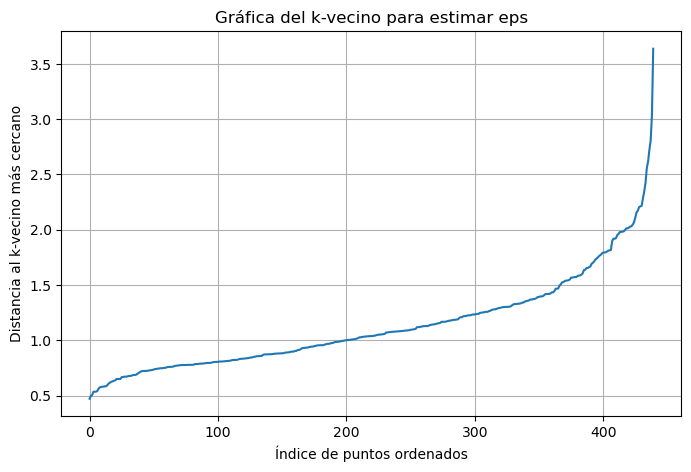

In [13]:
from sklearn.neighbors import NearestNeighbors

# Calcular las distancias del k-Vecino Más Cercano
neighbors = NearestNeighbors(n_neighbors=3)  # Usualmente min_samples+1
neighbors_fit = neighbors.fit(final_df)
distances, indices = neighbors_fit.kneighbors(final_df)

# Ordenar las distancias
distances = np.sort(distances[:, -1])

# Graficar las distancias para estimar eps
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('Gráfica del k-vecino para estimar eps')
plt.xlabel('Índice de puntos ordenados')
plt.ylabel('Distancia al k-vecino más cercano')
plt.grid()
plt.show()

0.42153475138114144


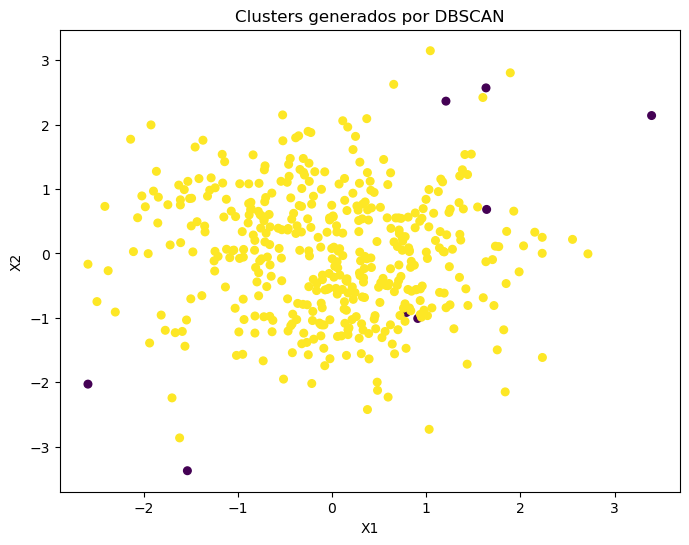

In [14]:

# Aplicar DBSCAN a los componentes principales
dbscan = DBSCAN(eps=2, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)

# Calculamos el Siboulette Score
score = silhouette_score(X_scaled, clusters)
print(score)
# Visualizar los clusters generados por DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=30)
plt.title("Clusters generados por DBSCAN")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

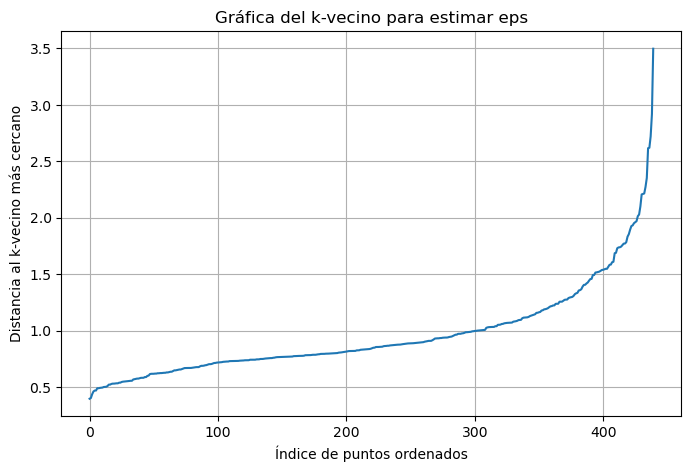

Outliers identificados: 35


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Calcular las distancias del k-vecino más cercano
neighbors = NearestNeighbors(n_neighbors=3)  # min_samples + 1
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Ordenar las distancias
distances = np.sort(distances[:, -1])

# Graficar las distancias para estimar eps
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('Gráfica del k-vecino para estimar eps')
plt.xlabel('Índice de puntos ordenados')
plt.ylabel('Distancia al k-vecino más cercano')
plt.grid()
plt.show()

# Ajustar el modelo DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Ajusta eps y min_samples según la gráfica
clusters = dbscan.fit_predict(X_scaled)

# Identificar outliers
outliers = np.sum(clusters == -1)
print(f"Outliers identificados: {outliers}")

# Calcular el Silhouette Score (excluyendo outliers)
if len(set(clusters)) > 1:  # Si hay más de un cluster
    score = silhouette_score(X_scaled[clusters != -1], clusters[clusters != -1])
    print(f"Silhouette Score (sin outliers): {score}")
else:
    print("No se puede calcular el Silhouette Score debido a que hay solo un cluster.")

# Visualizar los clusters generados
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=30)
plt.title("Clusters generados por DBSCAN")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


In [16]:

unique_clusters = np.unique(clusters)
print(f"Clusters únicos encontrados: {unique_clusters}")
print(f"Número de puntos en cada cluster: {np.bincount(clusters + 1)}")


Clusters únicos encontrados: [-1  0]
Número de puntos en cada cluster: [ 35 405]



4. Visualización de clusters y outliers:
  - Visualiza los clusters formados por DBSCAN en gráficos de dispersión. Utiliza diferentes colores para representar los clusters y marca los outliers con un color distintivo para hacer visible su presencia.
  - Discute la estructura de los clusters encontrados. ¿Hay alguna correlación entre las variables y los clusters? ¿Cómo se distribuyen los outliers en comparación con los datos agrupados?



5. Interpretación de resultados:
  - Evalúa la calidad del agrupamiento. DBSCAN no requiere que se especifique el número de clusters, lo que es una ventaja cuando no se conoce esta información de antemano.
  - Discute la naturaleza de los outliers detectados. ¿Son clientes únicos con comportamientos inusuales? ¿Podrían estos clientes representar oportunidades comerciales o riesgos?





Análisis de Resultados:

  - En esta sección, realiza un análisis detallado de los clusters formados y de los outliers. Utiliza métricas como el «silhouette score» para evaluar la calidad del agrupamiento, aunque es importante recordar que DBSCAN no siempre forma clusters compactos, por lo que estas métricas deben interpretarse con cuidado.



  - Genera un reporte que explique los valores de epsilon y min_samples elegidos, y justifica por qué esos valores fueron adecuados para este dataset. Analiza si los clusters formados tienen sentido desde una perspectiva comercial o de comportamiento del cliente.





Conclusión:

  - Esta actividad tiene como objetivo principal el uso de DBSCAN para encontrar agrupamientos en datos que pueden no formar clusters bien definidos. También busca desarrollar habilidades para la detección de outliers y para el ajuste de los parámetros de un modelo no supervisado.